# The Problem with Finding Domain Length and Area

In order to find network properties such as permeability using Darcy's law, it is necessary to know the domain length and area.  At first glance this might seem as simple as finding the maxima and minima of the pore coordinates in the direction of interest; however it is a bit more subtle than that as will be explained in this notebook.  Consider the simple cubic network:

In [1]:
import openpnm as op
import numpy as np
np.random.seed(10)
pn = op.network.Cubic(shape=[4, 4, 1])

Now let's plot the coordinates and connections between them:

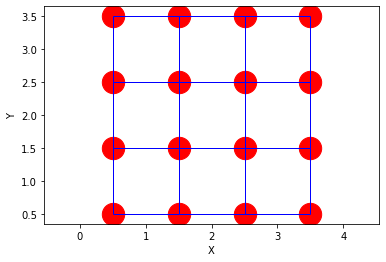

In [2]:
# NBVAL_IGNORE_OUTPUT
fig = op.topotools.plot_coordinates(pn, markersize=500)
fig = op.topotools.plot_connections(pn, fig=fig)

Let's say we'd like to know the length of the domain from left to right.  The pore coordinates for the leftmost pores are:

In [3]:
pn['pore.coords'][pn.pores('left'), :]

array([[0.5, 0.5, 0.5],
       [0.5, 1.5, 0.5],
       [0.5, 2.5, 0.5],
       [0.5, 3.5, 0.5]])

Note that the 'minimum' value is 0.5 rather than 0.0.  This is because the pore coordinates point to the center of the region that belongs to the pore.  In the case of the simple cubic with a spacing of 1, pore 0 lies at [0.5, 0.5, 0.5], while the bounding box around the pore goes from [0, 0, 0], to [1, 1, 1].  

Therefore, if we use pore coordinates to find the domain length we'd do:

In [4]:
L = pn['pore.coords'][:, 0].max() - pn['pore.coords'][:, 0].min()
print(L)

3.0


While in reality to domain is 4 pore long and the correct answer should be 4.0.  The extra 0.5 of the left and right cells are not included.  

It may seem simple enough to automatically add a full lattice cell to the calculation, but this cannot be assumed since many networks are random.  Consider the Delaunay network:

In [5]:
dn = op.network.Delaunay(num_points=20, shape=[1, 1, 0])

Let's first remove the boundary pores to ensure the network is fully random:

In [6]:
op.topotools.trim(network=dn, pores=dn.pores(['left', 'right', 'front', 'back']))

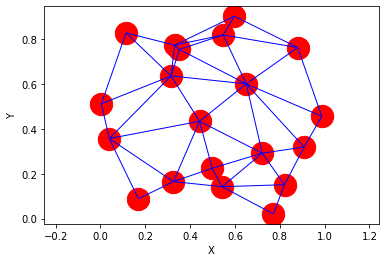

In [7]:
# NBVAL_IGNORE_OUTPUT
fig = op.topotools.plot_coordinates(dn, markersize=500)
fig = op.topotools.plot_connections(dn, fig=fig)

Now it's quite clear that finding the domain size by assuming a bounding box around the pore coordinates does not tell the whole story. How much 'extra' length should be added beyond the extreme pores?  This is not possible to know based only on the pore coordinates, which is the only information OpenPNM has.

The end result of this scenario is that when computing anything that requires length and area, these values must be specified by the user. Consider the permeability coefficient:

In [8]:
pn = op.network.Cubic(shape=[4, 4, 4])
geo = op.geometry.StickAndBall2D(network=pn, pores=pn.Ps, throats=pn.Ts)
air = op.phases.Air(network=pn)
phys = op.physics.Standard2D(network=pn, phase=air, geometry=geo)

In [9]:
sf = op.algorithms.StokesFlow(network=pn, phase=air)
sf.set_value_BC(pores=pn.pores('left'), values=200000)
sf.set_value_BC(pores=pn.pores('right'), values=100000)
sf.run()

If you do not specify the domain area and length, OpenPNM will attempt to estimate these values using the faulty logic of minima and maxima of boundary pores, but will issue a warning so you know that errors are present. 

In [10]:
# NBVAL_IGNORE_OUTPUT
K = sf.calc_effective_permeability()
print(K)

------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2021-04-24 19:32:54,304
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2021-04-24 19:32:54,308
------------------------------------------------------------


[0.00152148]


To get correct answers, it is necessary to specify the domain sizes as follows:

In [11]:
A = 16
L = 4
K = sf.calc_effective_permeability(domain_area=A, domain_length=L)
print(K)

[0.00114111]


Of course, the most correct way to calculate K is to do it manually using Darcy's law:

In [12]:
mu = air['pore.viscosity'].mean()
Q = sf.rate(pores=pn.pores('left'))
dP = 200000 - 100000
K = Q*mu*L/(A * dP)
print(K)

[0.00114111]
